[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alvaro-francisco-gil/nn4nlp/blob/main/exercises/04_transformers_and_contextuals.ipynb) 
[![View on GitHub](https://img.shields.io/badge/Open%20on-GitHub-blue?logo=github)](https://github.com/alvaro-francisco-gil/nn4nlp/blob/main/exercises/04_transformers_and_contextuals.ipynb)



If you are running this notebook in Google Colab, you can install the required packages by running the following cell:


In [1]:
# !pip install torch transformers pandas numpy seaborn matplotlib

In [2]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.optim import AdamW
import time
from tqdm import tqdm
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import (
    BertForSequenceClassification,
    XLNetForSequenceClassification,
    get_linear_schedule_with_warmup,
    AutoTokenizer
)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Analyze Data

In [3]:
train_file = '../data/train_reviews.csv'
df = pd.read_csv(train_file)
df.head()

,id,review,sentiment
0,17527,People tried to make me believe that the premi...,negative
1,24155,I have been wanting to see cut since the day i...,positive
2,21972,This movie is terrible. The suspense is spent ...,negative
3,4565,I hope she can keep acting and directing. She'...,positive
4,22098,I fell in love with this silent action drama. ...,positive


In [4]:
df.shape

(8000, 3)

In [5]:
test_file = '../data/test_reviews.csv'
test_df = pd.read_csv(test_file)
test_df.head()

,id,review,sentiment
0,6666,Movies about dinosaurs can be entertaining. So...,negative
1,23267,If it's action and adventure you want in a mov...,positive
2,2897,Barbra Streisand is a tour de force in this Ho...,positive
3,23177,I borrowed this movie despite its extremely lo...,positive
4,14171,"""Baby Face"" is a precode melodrama starring a ...",positive


In [6]:
test_df.shape

(2000, 3)

## Check class balance

In [7]:
df.value_counts('sentiment')

sentiment
positive    4012
negative    3988
Name: count, dtype: int64

In [8]:
test_df.value_counts('sentiment')

sentiment
negative    1025
positive     975
Name: count, dtype: int64

Both classes are balanced

## Check missing values

In [9]:
df.isna().sum()


id           0
review       0
sentiment    0
dtype: int64

In [10]:
test_df.isna().sum()

id           0
review       0
sentiment    0
dtype: int64

## Visual Inspection

In [11]:
df.iloc[1]['review']

"I have been wanting to see cut since the day i have heard of it, which was sometime last year. Anyway i got to see today, and when the movie started i thought that it started rather week but it got better after 10 mins or so. I thought that the movie was pretty good. but the thing i didn't like was how the killer was created, i was thinking just before i rented that it would probably suck just like Urban legends: final cut, i almost died it. mostly everything in UL final cut needed to be improved. CUT is 100 times better than UL:final cut. The best part of CUT is the killer and the death scenes. The killer kicks MO F***ING ASS.<br /><br />i give cut a 8 out of 10"

In [12]:
df.iloc[2]['review']

'This movie is terrible. The suspense is spent waiting for a point. There isn\'t much of one.<br /><br />Aside from a few great lines ( "I found a tooth in my apartment" ), and the main characters dedication to killing himself, it\'s a collection of supposedly eerie sounds.<br /><br />'

Insigths:
- Need to remove HTML labels

## Word Histogram

In [13]:
def plot_word_histogram(text_array):
    # Convert input to a flat list of strings
    if isinstance(text_array, str):
        # If it's a single string, convert to list
        text_array = [text_array]
    elif isinstance(text_array, list):
        # Flatten nested lists and ensure all elements are strings
        flattened = []
        for item in text_array:
            if isinstance(item, list):
                flattened.extend(item)
            else:
                flattened.append(item)
        text_array = [str(item) for item in flattened]
    else:
        raise ValueError("Input must be a string or a list of strings.")

    # Join all text into one string
    all_text = ' '.join(text_array)

    # Tokenize words by splitting on whitespace
    words = all_text.split()

    # Count word frequencies
    word_counts = Counter(words)
    labels, values = zip(*word_counts.items())

    # Sort by frequency in descending order
    sorted_indices = np.argsort(values)[::-1]
    labels = np.array(labels)[sorted_indices]
    values = np.array(values)[sorted_indices]

    # Plot the histogram for the top 10 most frequent words
    plt.figure(figsize=(10, 6))
    plt.bar(labels[:10], values[:10], color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.title('Top 10 Most Frequent Words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

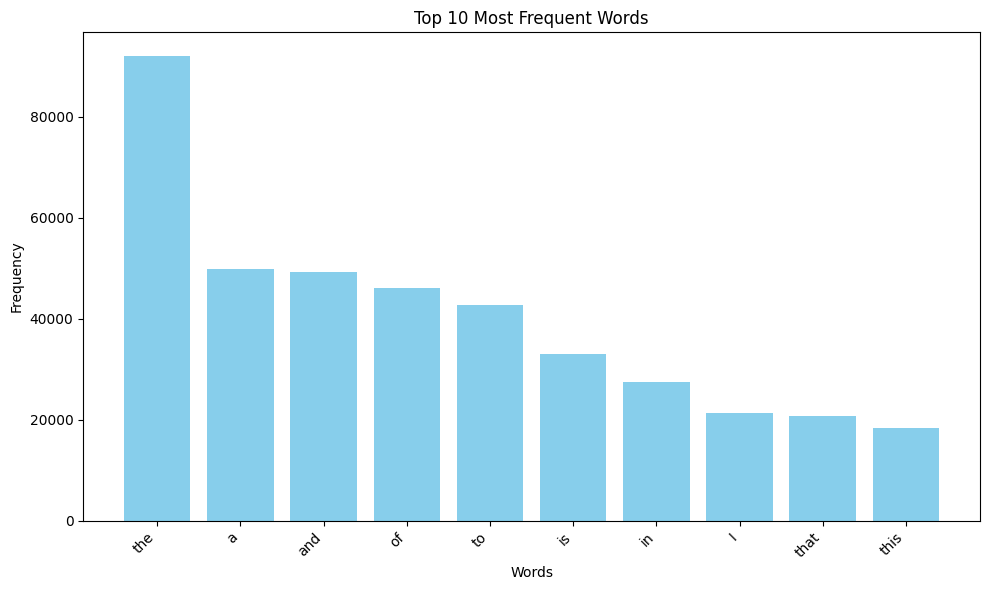

In [14]:
plot_word_histogram(df['review'].to_list())

# Pre-processing

In this case, minimal preprocessing is required since the BERT tokenizer will handle most of the preprocessing tasks.

In [15]:
data = np.concatenate([df['review'].values,test_df['review'].values],axis=0)
raw_data = data
data.shape

(10000,)

## Remove HTML labels

In [16]:
def clean_htmls_text_array(text_array):

    def remove_html_tags(text):
        pattern = re.compile('<.*?>')
        clean_text = re.sub(pattern, '', text)
        clean_text = ' '.join(clean_text.split())
        return clean_text

    cleaned_array = [remove_html_tags(text) for text in text_array]

    return cleaned_array

In [17]:
data[1][-40:]

'ASS.<br /><br />i give cut a 8 out of 10'

In [18]:
data = clean_htmls_text_array(data)

In [19]:
data[1][-40:]

' MO F***ING ASS.i give cut a 8 out of 10'

## Retain numbers

I don't want to remove the numbers as they may contain valuable information for the classifier, as in this case: "8 out of 10"

I test the hypothesis:

In [20]:
def find_term_with_context(text_array, term, context_chars=5):
    occurrences = 0
    occurrences_list = []

    for text in text_array:
        start = 0
        while (start := text.find(term, start)) != -1:
            occurrences += 1
            context_start = max(0, start - context_chars)
            context_end = min(len(text), start + len(term) + context_chars)
            context = text[context_start:context_end]

            occurrences_list.append(f"...{context}...")
            start += len(term)

    print(f"\nTotal occurrences of '{term}': {occurrences}")
    return occurrences, occurrences_list

In [21]:
_,ocurrences = find_term_with_context(data, 'out of')
ocurrences[1]


Total occurrences of 'out of': 2029


'... a 3 out of 10, ...'

We see that 2070 reviews contain a possible explicit grade

# Splitting

Take Labels

In [22]:
combined_sentiments = np.concatenate([df['sentiment'].values, test_df['sentiment'].values])
combined_sentiments.shape

(10000,)

In [23]:
label_map = {"positive": 1, "negative": 0}
combined_sentiments = np.array([label_map[label] for label in combined_sentiments])

Data Splitting

In [24]:
train_texts, test_texts = data[:8000], data[8000:]
train_labels, test_labels = combined_sentiments[:8000], combined_sentiments[8000:]

In [25]:
type(train_texts)
type(train_labels[0])


numpy.int64

Create Validation Set

In [26]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.1, random_state=42
)

# Modelling

The models we're going to try are BERT and XLNet
 
We're using BERT as a baseline model since it was one of the first transformer models to achieve state-of-the-art results on many NLP tasks.
XLNet is an advanced model that outperforms BERT on many benchmarks and is currently ranked first on the NLP Progress leaderboard for sentiment analysis (https://nlpprogress.com/english/sentiment_analysis.html).
XLNet improves upon BERT by using a permutation-based training method that overcomes limitations of BERT's masked language modeling approach.

## Training and Validation Loop
Purpose: This core function handles the entire training and validation process for any transformer model.
- We need a unified training loop that can work for both BERT and XLNet to ensure fair comparison
- The function needs to track both training and validation metrics across epochs
- We need to capture training time to compare model efficiency
- We use the same hyperparameters (learning rate, optimizer, etc.) for both models for fair comparison

In [27]:
# Function for model training and evaluation
def train_evaluate_model(model, train_dataloader, val_dataloader, epochs=10):
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    
    # Total number of training steps
    total_steps = len(train_dataloader) * epochs
    
    # Create the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=total_steps
    )
    
    # Training loop
    training_stats = []
    total_training_time = 0
    
    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1}/{epochs}')
        
        # Training
        model.train()
        total_loss = 0
        start_time = time.time()
        
        for batch in tqdm(train_dataloader, desc="Training"):
            batch = tuple(b.to(device) for b in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'labels': batch[2]}
            
            # Clear any previously calculated gradients
            model.zero_grad()
            
            # Forward pass
            outputs = model(**inputs)
            loss = outputs.loss
            total_loss += loss.item()
            
            # Backward pass to calculate gradients
            loss.backward()
            
            # Clip the norm of the gradients to 1.0 to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            # Update parameters and take a step using the computed gradient
            optimizer.step()
            
            # Update the learning rate
            scheduler.step()
        
        epoch_time = time.time() - start_time
        total_training_time += epoch_time
        avg_train_loss = total_loss / len(train_dataloader)
        
        print(f"Training Loss: {avg_train_loss:.4f}")
        print(f"Training epoch took: {epoch_time:.4f} seconds")
        
        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_true = []
        
        for batch in tqdm(val_dataloader, desc="Validation"):
            batch = tuple(b.to(device) for b in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'labels': batch[2]}
            
            with torch.no_grad():
                outputs = model(**inputs)
            
            loss = outputs.loss
            val_loss += loss.item()
            
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).flatten()
            val_preds.extend(preds.cpu().numpy())
            val_true.extend(inputs['labels'].cpu().numpy())
        
        avg_val_loss = val_loss / len(val_dataloader)
        val_accuracy = accuracy_score(val_true, val_preds)
        
        print(f"Validation Loss: {avg_val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        
        training_stats.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy,
            'epoch_time': epoch_time,
        })
    
    print(f"\nTotal training time: {total_training_time:.4f} seconds")
    return training_stats

## Evaluation Function
Purpose: Provides standardized evaluation of model performance on unseen test data.
- We need a consistent way to evaluate both models on the same test set
- The function should return both the overall accuracy and detailed prediction information
- Classification reports give a more nuanced understanding of performance across classes
- This separated evaluation function ensures both models are tested in exactly the same way

In [28]:
def evaluate_model(model, test_dataloader):
    model.eval()
    test_preds = []
    test_true = []
    
    for batch in tqdm(test_dataloader, desc="Testing"):
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).flatten()
        test_preds.extend(preds.cpu().numpy())
        test_true.extend(inputs['labels'].cpu().numpy())
    
    test_accuracy = accuracy_score(test_true, test_preds)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(test_true, test_preds, target_names=['negative', 'positive']))
    
    return test_accuracy, test_preds

## Plot Comparison
Purpose: Provides standardized evaluation of model performance on unseen test data.
- We need a consistent way to evaluate both models on the same test set
- The function should return both the overall accuracy and detailed prediction information
- Classification reports give a more nuanced understanding of performance across classes
- This separated evaluation function ensures both models are tested in exactly the same way

In [29]:
def plot_comparison(bert_stats, xlnet_stats):
    """Plot comparison between BERT and XLNet training metrics"""
    epochs = range(1, len(bert_stats) + 1)
    
    plt.figure(figsize=(15, 5))
    
    # Training loss
    plt.subplot(1, 3, 1)
    plt.plot([s['train_loss'] for s in bert_stats], 'b-o', label='BERT')
    plt.plot([s['train_loss'] for s in xlnet_stats], 'r-o', label='XLNet')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Validation loss
    plt.subplot(1, 3, 2)
    plt.plot([s['val_loss'] for s in bert_stats], 'b-o', label='BERT')
    plt.plot([s['val_loss'] for s in xlnet_stats], 'r-o', label='XLNet')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Validation accuracy
    plt.subplot(1, 3, 3)
    plt.plot([s['val_accuracy'] for s in bert_stats], 'b-o', label='BERT')
    plt.plot([s['val_accuracy'] for s in xlnet_stats], 'r-o', label='XLNet')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('bert_xlnet_comparison.png')
    plt.show()

## BERT Model Implementation
Purpose: Encapsulates the complete BERT implementation workflow.
- We need to isolate BERT-specific processing from the general training loop
- BERT requires specific tokenization that differs from XLNet:
  - Uses an uncased vocabulary (lowercase)
  - Has its own tokenization rules and special tokens
- We need sequential steps: tokenize → create datasets → create data loaders → initialize model → train → evaluate
- Encapsulating this in a function keeps our code organized and modular

In [30]:
def run_bert(train_texts, val_texts, test_texts, train_labels, val_labels, test_labels):
    print("\n======= Running BERT Model =======\n")
    # Tokenizing with BERT
    bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    
    def tokenize_bert(texts):
        return bert_tokenizer(
            texts, 
            truncation=True, 
            padding='max_length', 
            max_length=128,
            return_tensors='pt'
        )
    
    # Tokenize datasets
    train_encodings = tokenize_bert(train_texts)
    val_encodings = tokenize_bert(val_texts)
    test_encodings = tokenize_bert(test_texts)
    
    # Create dataset objects
    train_dataset = TensorDataset(
        train_encodings['input_ids'],
        train_encodings['attention_mask'],
        torch.tensor(train_labels)
    )
    
    val_dataset = TensorDataset(
        val_encodings['input_ids'],
        val_encodings['attention_mask'],
        torch.tensor(val_labels)
    )
    
    test_dataset = TensorDataset(
        test_encodings['input_ids'],
        test_encodings['attention_mask'],
        torch.tensor(test_labels)
    )
    
    # Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=32)
    test_dataloader = DataLoader(test_dataset, batch_size=32)
    
    # Load BERT model
    bert_model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2
    ).to(device)
    
    # Train and evaluate
    bert_stats = train_evaluate_model(bert_model, train_dataloader, val_dataloader)
    bert_accuracy, bert_preds = evaluate_model(bert_model, test_dataloader)
    
    return bert_accuracy, bert_stats, bert_model

## XLNet Model Implementation
Purpose: Encapsulates the complete XLNet implementation workflow.
- Similar structure to the BERT function, but with XLNet-specific details
- XLNet requires different tokenization:
  - Uses a cased vocabulary (preserves case)
  - Has different special tokens and formatting requirements
- Using a parallel function structure to run_bert makes the comparison clean and fair
- Maintaining consistency in the workflow ensures differences are due to the models, not implementation details

In [31]:
# XLNet model implementation
def run_xlnet(train_texts, val_texts, test_texts, train_labels, val_labels, test_labels):
    print("\n======= Running XLNet Model =======\n")
    # Tokenizing with XLNet
    xlnet_tokenizer = AutoTokenizer.from_pretrained('xlnet-base-cased')
    
    # XLNet has different formatting requirements
    def tokenize_xlnet(texts):
        return xlnet_tokenizer(
            texts, 
            truncation=True, 
            padding='max_length', 
            max_length=128,
            return_tensors='pt'
        )
    
    # Tokenize datasets
    train_encodings = tokenize_xlnet(train_texts)
    val_encodings = tokenize_xlnet(val_texts)
    test_encodings = tokenize_xlnet(test_texts)
    
    # Create dataset objects
    train_dataset = TensorDataset(
        train_encodings['input_ids'],
        train_encodings['attention_mask'],
        torch.tensor(train_labels)
    )
    
    val_dataset = TensorDataset(
        val_encodings['input_ids'],
        val_encodings['attention_mask'],
        torch.tensor(val_labels)
    )
    
    test_dataset = TensorDataset(
        test_encodings['input_ids'],
        test_encodings['attention_mask'],
        torch.tensor(test_labels)
    )
    
    # Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=32)
    test_dataloader = DataLoader(test_dataset, batch_size=32)
    
    # Load XLNet model
    xlnet_model = XLNetForSequenceClassification.from_pretrained(
        'xlnet-base-cased',
        num_labels=2
    ).to(device)
    
    # Train and evaluate
    xlnet_stats = train_evaluate_model(xlnet_model, train_dataloader, val_dataloader)
    xlnet_accuracy, xlnet_preds = evaluate_model(xlnet_model, test_dataloader)
    
    return xlnet_accuracy, xlnet_stats, xlnet_model

## Time Comparison Analysis
Purpose: Provides a comprehensive comparison of training times between BERT and XLNet.
- We need to track both total training time and per-epoch timing
- This helps us understand the performance vs. time trade-off for each model
- We can also calculate speedup/slowdown percentages to highlight relative efficiency
- This analysis is crucial for understanding the practical performance of each model

In [32]:
# Time comparison analysis
def create_time_comparison_plots(bert_stats, xlnet_stats):
    # Extract timing data
    bert_times = [stat['epoch_time'] for stat in bert_stats]
    xlnet_times = [stat['epoch_time'] for stat in xlnet_stats]
    
    # Calculate total times
    bert_total = sum(bert_times)
    xlnet_total = sum(xlnet_times)
    
    # Create time comparison bar chart
    plt.figure(figsize=(12, 6))
    
    # Epoch-wise timing comparison
    plt.subplot(1, 2, 1)
    epochs = range(1, len(bert_times) + 1)
    width = 0.35
    
    plt.bar([x - width/2 for x in epochs], bert_times, width, label='BERT', color='royalblue')
    plt.bar([x + width/2 for x in epochs], xlnet_times, width, label='XLNet', color='firebrick')
    
    plt.xlabel('Epoch')
    plt.ylabel('Time (seconds)')
    plt.title('Training Time per Epoch')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Total time comparison
    plt.subplot(1, 2, 2)
    plt.bar(['BERT', 'XLNet'], [bert_total, xlnet_total], color=['royalblue', 'firebrick'])
    plt.ylabel('Time (seconds)')
    plt.title('Total Training Time')
    
    # Add values on top of the bars
    for i, v in enumerate([bert_total, xlnet_total]):
        plt.text(i, v + 5, f"{v:.1f}s", ha='center')
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Calculate the speedup/slowdown
    speedup = (xlnet_total - bert_total) / xlnet_total * 100 if xlnet_total > bert_total else (bert_total - xlnet_total) / bert_total * 100
    faster_model = "BERT" if bert_total < xlnet_total else "XLNet"
    
    plt.figtext(0.5, 0.01, f"{faster_model} was {speedup:.1f}% faster", ha="center", fontsize=12, bbox={"facecolor":"yellow", "alpha":0.5})
    
    plt.tight_layout()
    plt.show()
    
    # Return timing info for further analysis
    return {
        'bert_times': bert_times,
        'xlnet_times': xlnet_times,
        'bert_total': bert_total,
        'xlnet_total': xlnet_total,
        'faster_model': faster_model,
        'speedup_percentage': speedup
    }


## Training Time vs. Performance Analysis
Purpose: Visualizes the relationship between training time and model performance.
- We need to understand how training time affects model accuracy
- This helps us identify the trade-off between training speed and model quality
- It also allows us to compare the convergence rates of different models
- This analysis is useful for understanding the practical performance of each model


In [33]:
def plot_time_vs_performance(bert_stats, xlnet_stats, bert_accuracy, xlnet_accuracy):
    # Calculate cumulative training time at each epoch
    bert_cumulative_times = []
    xlnet_cumulative_times = []
    
    bert_time = 0
    xlnet_time = 0
    
    for i in range(len(bert_stats)):
        bert_time += bert_stats[i]['epoch_time']
        bert_cumulative_times.append(bert_time)
        
        if i < len(xlnet_stats):  # In case the number of epochs differ
            xlnet_time += xlnet_stats[i]['epoch_time']
            xlnet_cumulative_times.append(xlnet_time)
    
    # Plot accuracy vs. cumulative training time
    plt.figure(figsize=(10, 6))
    
    # Plot validation accuracy vs. cumulative time
    plt.plot(bert_cumulative_times, [s['val_accuracy'] for s in bert_stats], 'bo-', label='BERT Val Accuracy')
    plt.plot(xlnet_cumulative_times, [s['val_accuracy'] for s in xlnet_stats], 'ro-', label='XLNet Val Accuracy')
    
    # Add test accuracy as endpoints
    plt.plot(bert_cumulative_times[-1], bert_accuracy, 'bs', markersize=10, label='BERT Test Accuracy')
    plt.plot(xlnet_cumulative_times[-1], xlnet_accuracy, 'rs', markersize=10, label='XLNet Test Accuracy')
    
    plt.xlabel('Cumulative Training Time (seconds)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Training Time')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Add annotations
    for i, (time, acc) in enumerate(zip(bert_cumulative_times, [s['val_accuracy'] for s in bert_stats])):
        plt.annotate(f"Epoch {i+1}", (time, acc), textcoords="offset points", xytext=(0,10), ha='center')
        
    for i, (time, acc) in enumerate(zip(xlnet_cumulative_times, [s['val_accuracy'] for s in xlnet_stats])):
        plt.annotate(f"Epoch {i+1}", (time, acc), textcoords="offset points", xytext=(0,-15), ha='center')
    
    plt.tight_layout()
    plt.show()

# Executing the models

In [34]:
SAMPLE_SIZE = 1000

# Run BERT model
bert_accuracy, bert_stats, bert_model = run_bert(train_texts, val_texts, test_texts, train_labels, val_labels, test_labels)

# Run XLNet model
xlnet_accuracy, xlnet_stats, xlnet_model = run_xlnet(train_texts, val_texts, test_texts, train_labels, val_labels, test_labels)


======= Running BERT Model =======



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/10


Training: 100%|██████████| 450/450 [00:41<00:00, 10.98it/s]


Training Loss: 0.4061
Training epoch took: 41.0034 seconds


Validation: 100%|██████████| 25/25 [00:01<00:00, 19.65it/s]


Validation Loss: 0.2971
Validation Accuracy: 0.8625

Epoch 2/10


Training: 100%|██████████| 450/450 [00:40<00:00, 11.03it/s]


Training Loss: 0.2207
Training epoch took: 40.8091 seconds


Validation: 100%|██████████| 25/25 [00:01<00:00, 19.64it/s]


Validation Loss: 0.4460
Validation Accuracy: 0.8650

Epoch 3/10


Training: 100%|██████████| 450/450 [00:40<00:00, 11.02it/s]


Training Loss: 0.1158
Training epoch took: 40.8438 seconds


Validation: 100%|██████████| 25/25 [00:01<00:00, 19.72it/s]


Validation Loss: 0.6591
Validation Accuracy: 0.8675

Epoch 4/10


Training: 100%|██████████| 450/450 [00:40<00:00, 10.99it/s]


Training Loss: 0.0538
Training epoch took: 40.9425 seconds


Validation: 100%|██████████| 25/25 [00:01<00:00, 19.67it/s]


Validation Loss: 0.7239
Validation Accuracy: 0.8688

Epoch 5/10


Training: 100%|██████████| 450/450 [00:40<00:00, 11.01it/s]


Training Loss: 0.0241
Training epoch took: 40.8782 seconds


Validation: 100%|██████████| 25/25 [00:01<00:00, 19.61it/s]


Validation Loss: 0.8112
Validation Accuracy: 0.8700

Epoch 6/10


Training: 100%|██████████| 450/450 [00:40<00:00, 10.98it/s]


Training Loss: 0.0100
Training epoch took: 40.9967 seconds


Validation: 100%|██████████| 25/25 [00:01<00:00, 19.71it/s]


Validation Loss: 0.9731
Validation Accuracy: 0.8688

Epoch 7/10


Training: 100%|██████████| 450/450 [00:40<00:00, 11.02it/s]


Training Loss: 0.0091
Training epoch took: 40.8221 seconds


Validation: 100%|██████████| 25/25 [00:01<00:00, 19.67it/s]


Validation Loss: 1.0002
Validation Accuracy: 0.8725

Epoch 8/10


Training: 100%|██████████| 450/450 [00:40<00:00, 11.01it/s]


Training Loss: 0.0013
Training epoch took: 40.8699 seconds


Validation: 100%|██████████| 25/25 [00:01<00:00, 19.67it/s]


Validation Loss: 1.0510
Validation Accuracy: 0.8712

Epoch 9/10


Training: 100%|██████████| 450/450 [00:40<00:00, 11.02it/s]


Training Loss: 0.0030
Training epoch took: 40.8244 seconds


Validation: 100%|██████████| 25/25 [00:01<00:00, 19.61it/s]


Validation Loss: 1.0783
Validation Accuracy: 0.8738

Epoch 10/10


Training: 100%|██████████| 450/450 [00:40<00:00, 11.02it/s]


Training Loss: 0.0025
Training epoch took: 40.8429 seconds


Validation: 100%|██████████| 25/25 [00:01<00:00, 19.66it/s]


Validation Loss: 1.0854
Validation Accuracy: 0.8738

Total training time: 408.8330 seconds


Testing: 100%|██████████| 63/63 [00:03<00:00, 20.57it/s]


Test Accuracy: 0.8805

Classification Report:
              precision    recall  f1-score   support

    negative       0.88      0.88      0.88      1025
    positive       0.88      0.88      0.88       975

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000


======= Running XLNet Model =======



Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/10


Training: 100%|██████████| 450/450 [00:52<00:00,  8.65it/s]


Training Loss: 0.3667
Training epoch took: 52.0323 seconds


Validation: 100%|██████████| 25/25 [00:01<00:00, 14.62it/s]


Validation Loss: 0.3390
Validation Accuracy: 0.9012

Epoch 2/10


Training: 100%|██████████| 450/450 [00:51<00:00,  8.69it/s]


Training Loss: 0.2319
Training epoch took: 51.8113 seconds


Validation: 100%|██████████| 25/25 [00:01<00:00, 14.62it/s]


Validation Loss: 0.3013
Validation Accuracy: 0.9012

Epoch 3/10


Training: 100%|██████████| 450/450 [00:51<00:00,  8.68it/s]


Training Loss: 0.1485
Training epoch took: 51.8533 seconds


Validation: 100%|██████████| 25/25 [00:01<00:00, 14.70it/s]


Validation Loss: 0.5365
Validation Accuracy: 0.8812

Epoch 4/10


Training: 100%|██████████| 450/450 [00:51<00:00,  8.69it/s]


Training Loss: 0.0928
Training epoch took: 51.7735 seconds


Validation: 100%|██████████| 25/25 [00:01<00:00, 14.64it/s]


Validation Loss: 0.6508
Validation Accuracy: 0.8875

Epoch 5/10


Training: 100%|██████████| 450/450 [00:51<00:00,  8.69it/s]


Training Loss: 0.0566
Training epoch took: 51.7663 seconds


Validation: 100%|██████████| 25/25 [00:01<00:00, 14.68it/s]


Validation Loss: 0.6388
Validation Accuracy: 0.8950

Epoch 6/10


Training: 100%|██████████| 450/450 [00:51<00:00,  8.70it/s]


Training Loss: 0.0324
Training epoch took: 51.7531 seconds


Validation: 100%|██████████| 25/25 [00:01<00:00, 14.80it/s]


Validation Loss: 0.7298
Validation Accuracy: 0.8950

Epoch 7/10


Training: 100%|██████████| 450/450 [00:51<00:00,  8.70it/s]


Training Loss: 0.0183
Training epoch took: 51.7363 seconds


Validation: 100%|██████████| 25/25 [00:01<00:00, 14.69it/s]


Validation Loss: 0.7644
Validation Accuracy: 0.8988

Epoch 8/10


Training: 100%|██████████| 450/450 [00:51<00:00,  8.69it/s]


Training Loss: 0.0156
Training epoch took: 51.7668 seconds


Validation: 100%|██████████| 25/25 [00:01<00:00, 14.79it/s]


Validation Loss: 0.7697
Validation Accuracy: 0.8975

Epoch 9/10


Training: 100%|██████████| 450/450 [00:51<00:00,  8.69it/s]


Training Loss: 0.0127
Training epoch took: 51.7848 seconds


Validation: 100%|██████████| 25/25 [00:01<00:00, 14.73it/s]


Validation Loss: 0.7755
Validation Accuracy: 0.8975

Epoch 10/10


Training: 100%|██████████| 450/450 [00:51<00:00,  8.70it/s]


Training Loss: 0.0059
Training epoch took: 51.7548 seconds


Validation: 100%|██████████| 25/25 [00:01<00:00, 14.70it/s]


Validation Loss: 0.7991
Validation Accuracy: 0.8988

Total training time: 518.0324 seconds


Testing: 100%|██████████| 63/63 [00:04<00:00, 15.40it/s]


Test Accuracy: 0.8935

Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.89      0.90      1025
    positive       0.88      0.90      0.89       975

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



# Results


======= Model Comparison =======
BERT Accuracy: 0.8805
XLNet Accuracy: 0.8935
XLNet outperformed BERT on this dataset

Training Statistics:
BERT:
Epoch 1: Train Loss = 0.4061, Val Loss = 0.2971, Val Accuracy = 0.8625
Epoch 2: Train Loss = 0.2207, Val Loss = 0.4460, Val Accuracy = 0.8650
Epoch 3: Train Loss = 0.1158, Val Loss = 0.6591, Val Accuracy = 0.8675
Epoch 4: Train Loss = 0.0538, Val Loss = 0.7239, Val Accuracy = 0.8688
Epoch 5: Train Loss = 0.0241, Val Loss = 0.8112, Val Accuracy = 0.8700
Epoch 6: Train Loss = 0.0100, Val Loss = 0.9731, Val Accuracy = 0.8688
Epoch 7: Train Loss = 0.0091, Val Loss = 1.0002, Val Accuracy = 0.8725
Epoch 8: Train Loss = 0.0013, Val Loss = 1.0510, Val Accuracy = 0.8712
Epoch 9: Train Loss = 0.0030, Val Loss = 1.0783, Val Accuracy = 0.8738
Epoch 10: Train Loss = 0.0025, Val Loss = 1.0854, Val Accuracy = 0.8738

XLNet:
Epoch 1: Train Loss = 0.3667, Val Loss = 0.3390, Val Accuracy = 0.9012
Epoch 2: Train Loss = 0.2319, Val Loss = 0.3013, Val Accuracy =

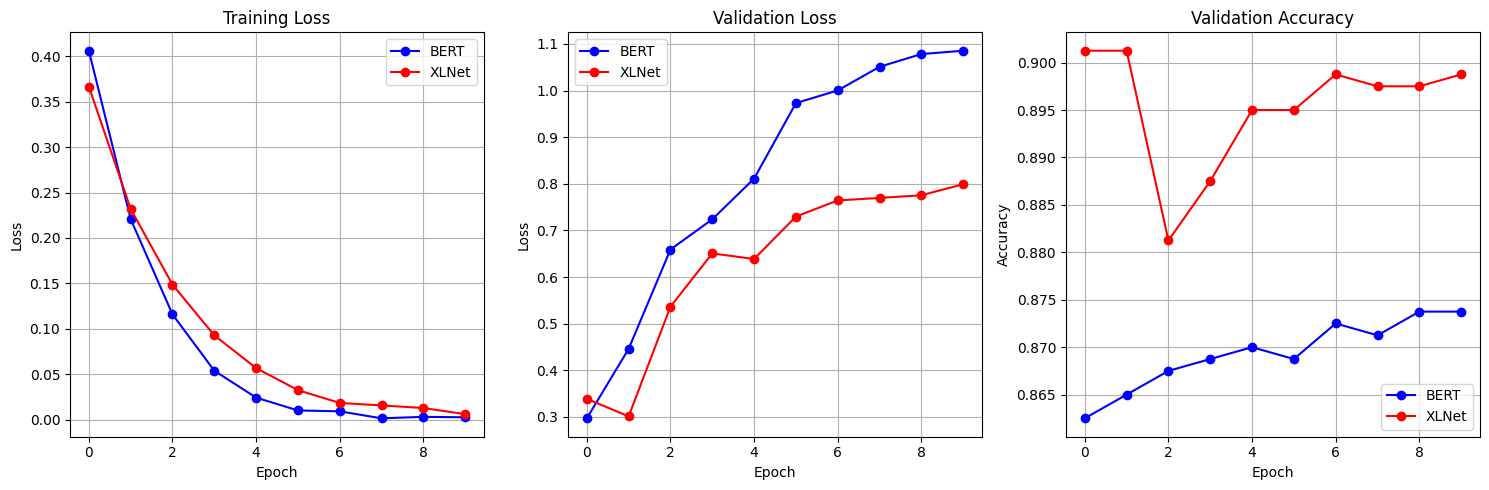


Key findings:
1. Training time comparison:
   - BERT total training time: 408.83 seconds
   - XLNet total training time: 518.03 seconds

2. Final performance:
   - BERT test accuracy: 0.8805
   - XLNet test accuracy: 0.8935

3. Learning curve:
   - BERT validation accuracy evolution: [0.8625, 0.8650, 0.8675, 0.8688, 0.8700, 0.8688, 0.8725, 0.8712, 0.8738, 0.8738]
   - XLNet validation accuracy evolution: [0.9012, 0.9012, 0.8812, 0.8875, 0.8950, 0.8950, 0.8988, 0.8975, 0.8975, 0.8988]


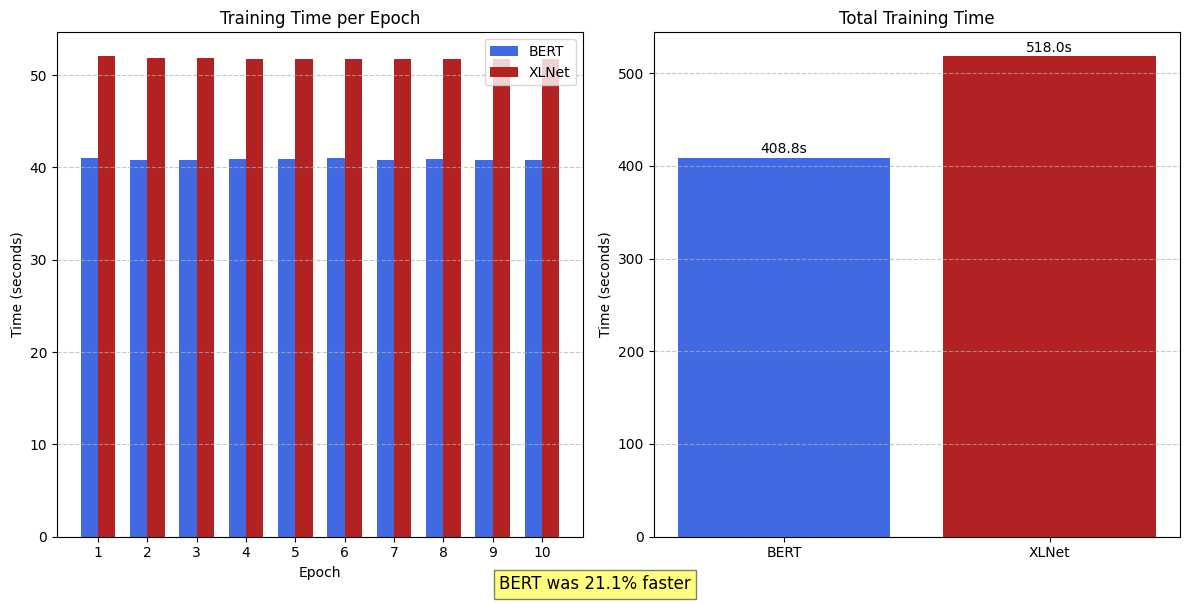

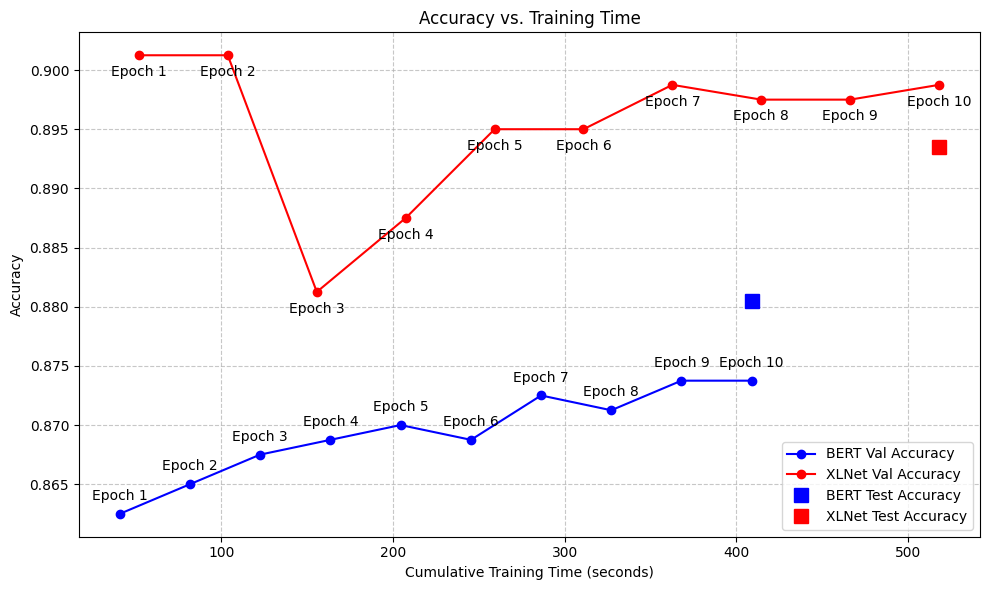


=== Detailed Time Analysis ===
BERT average epoch time: 40.88 seconds
XLNet average epoch time: 51.80 seconds

Training time per sample:
BERT: 56.78 milliseconds/sample
XLNet: 71.95 milliseconds/sample

Efficiency analysis (accuracy per second of training):
BERT: 0.2154% accuracy per second of training
XLNet: 0.1725% accuracy per second of training

BERT is 1.25x more efficient in terms of accuracy per training time.


In [35]:
# Compare results
print("\n======= Model Comparison =======")
print(f"BERT Accuracy: {bert_accuracy:.4f}")
print(f"XLNet Accuracy: {xlnet_accuracy:.4f}")

if bert_accuracy > xlnet_accuracy:
    print("BERT outperformed XLNet on this dataset")
elif xlnet_accuracy > bert_accuracy:
    print("XLNet outperformed BERT on this dataset")
else:
    print("Both models performed equally well")

print("\nTraining Statistics:")
print("BERT:")
for stat in bert_stats:
    print(f"Epoch {stat['epoch']}: Train Loss = {stat['train_loss']:.4f}, Val Loss = {stat['val_loss']:.4f}, Val Accuracy = {stat['val_accuracy']:.4f}")

print("\nXLNet:")
for stat in xlnet_stats:
    print(f"Epoch {stat['epoch']}: Train Loss = {stat['train_loss']:.4f}, Val Loss = {stat['val_loss']:.4f}, Val Accuracy = {stat['val_accuracy']:.4f}")

# Plot comparison
plot_comparison(bert_stats, xlnet_stats)

# Calculate and display total training times
print("\nKey findings:")
print("1. Training time comparison:")
bert_time = sum(stat['epoch_time'] for stat in bert_stats)
xlnet_time = sum(stat['epoch_time'] for stat in xlnet_stats)
print(f"   - BERT total training time: {bert_time:.2f} seconds")
print(f"   - XLNet total training time: {xlnet_time:.2f} seconds")

print("\n2. Final performance:")
print(f"   - BERT test accuracy: {bert_accuracy:.4f}")
print(f"   - XLNet test accuracy: {xlnet_accuracy:.4f}")

print("\n3. Learning curve:")
bert_val_accuracies = ", ".join([f"{stat['val_accuracy']:.4f}" for stat in bert_stats])
xlnet_val_accuracies = ", ".join([f"{stat['val_accuracy']:.4f}" for stat in xlnet_stats])
print(f"   - BERT validation accuracy evolution: [{bert_val_accuracies}]")
print(f"   - XLNet validation accuracy evolution: [{xlnet_val_accuracies}]")

# Run the time comparison analyses after training both models
time_comparison = create_time_comparison_plots(bert_stats, xlnet_stats)
plot_time_vs_performance(bert_stats, xlnet_stats, bert_accuracy, xlnet_accuracy)

# Print detailed time analysis
print("\n=== Detailed Time Analysis ===")
print(f"BERT average epoch time: {sum(time_comparison['bert_times'])/len(time_comparison['bert_times']):.2f} seconds")
print(f"XLNet average epoch time: {sum(time_comparison['xlnet_times'])/len(time_comparison['xlnet_times']):.2f} seconds")

# Time per sample analysis
num_train_samples = len(train_texts)
print(f"\nTraining time per sample:")
print(f"BERT: {time_comparison['bert_total']/num_train_samples*1000:.2f} milliseconds/sample")
print(f"XLNet: {time_comparison['xlnet_total']/num_train_samples*1000:.2f} milliseconds/sample")

# Performance vs time trade-off
print("\nEfficiency analysis (accuracy per second of training):")
bert_efficiency = bert_accuracy / time_comparison['bert_total'] * 100
xlnet_efficiency = xlnet_accuracy / time_comparison['xlnet_total'] * 100
print(f"BERT: {bert_efficiency:.4f}% accuracy per second of training")
print(f"XLNet: {xlnet_efficiency:.4f}% accuracy per second of training")

more_efficient = "BERT" if bert_efficiency > xlnet_efficiency else "XLNet"
efficiency_ratio = bert_efficiency/xlnet_efficiency if bert_efficiency > xlnet_efficiency else xlnet_efficiency/bert_efficiency
print(f"\n{more_efficient} is {efficiency_ratio:.2f}x more efficient in terms of accuracy per training time.")

Conclussion: Both models perform similarly well, but BERT is slightly faster and more efficient.

Thanks for reading the code, connect with me on [LinkedIn](https://www.linkedin.com/in/alvaro-francisco-gil/) or [GitHub](https://github.com/alvaro-francisco-gil) if you have any questions or comments.

*Álvaro Francisco Gil*